# Estimate Porosity using 3D image with 2 silces of rock images --- CNN

In [57]:
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
from skimage import io
import cv2
import os

In [58]:
raw_file = np.fromfile('Berea_2d25um_grayscale_filtered.raw', dtype=np.uint8)
image = (raw_file.reshape(1000,1000,1000))

### randomly crop sub-image from the RAW 3D image in the size of 256*256 2D image
#### crop 400 images in total

In [74]:
def random_crop_and_save(image, num_crops=400, crop_size=(256, 256), save_dir='CroppedImages'):

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    depth, height, width = image.shape
    for i in range(num_crops):
        # Randomly choose the top-left pixel of the crop
        z = np.random.randint(0, depth - crop_size[0])
        y = np.random.randint(0, height - crop_size[1])
        x = np.random.randint(0, width - crop_size[1])  # square crops (128x128)

        # Perform the crop
        cropped_image = image[z, y:y+crop_size[1], x:x+crop_size[1]]
        
        # Save the cropped image
        filename = os.path.join(save_dir, f'crop_{i+1:04d}.png')
        cv2.imwrite(filename, cropped_image)

random_crop_and_save(image)


### calculate porosity 

##### OTSU'method to make it binary image and using watersheld alriorithen to makea thersholds

In [75]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def calculate_porosity(image_path):
    
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, bin_img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel, iterations=2)

    sure_bg = cv2.dilate(bin_img, kernel, iterations=3)
    dist = cv2.distanceTransform(bin_img, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist, 0.1 * dist.max(), 255, cv2.THRESH_BINARY)
    sure_fg = sure_fg.astype(np.uint8)
    unknown = cv2.subtract(sure_bg, sure_fg)

    ret, markers = cv2.connectedComponents(sure_fg)
    markers += 1
    markers[unknown == 255] = 0

    markers = cv2.watershed(img, markers)

    labels = np.unique(markers)
    total_pore_area = 0

    for label in labels[2:]:  
        target = np.where(markers == label, 255, 0).astype(np.uint8)
        contours, hierarchy = cv2.findContours(target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        total_pore_area += cv2.contourArea(contours[0])

    total_image_area = img.shape[0] * img.shape[1]
    porosity = total_pore_area / total_image_area
    return porosity

cropped_images_dir = 'CroppedImages'
PorosityValues = {}

for i in range(1, 401): 
    filename = f"crop_{i:04d}.png"
    image_path = os.path.join(cropped_images_dir, filename)
    porosity = calculate_porosity(image_path)
    PorosityValues[filename] = porosity

# Optionally, save porosity values to a file
with open('PorosityValues.txt', 'w') as f:
    for filename, porosity in PorosityValues.items():
        f.write(f"{filename}: {porosity}\n")

### Spliting data

In [76]:
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import os

X = []
y = []

for filename, porosity in PorosityValues.items():
    img_path = os.path.join(cropped_images_dir, filename)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))  # Ensure all images are the same size
    X.append(img)
    y.append(porosity)

X = np.array(X).reshape(-1, 128, 128, 1)
y = np.array(y)



# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 * 0.4 = 0.1


### CNN MODLE Build up

In [81]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
CNNmodel = Sequential([
    
    # First Conv Block
    Input(shape=(128, 128, 1)), 
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=(2, 2), padding="same"),
    
    # Second Conv Block
    Conv2D(32, (3, 3), strides=(1, 1), padding="same", activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=(2, 2), padding="same"),
    
    # Third Conv Block
    Conv2D(64, (3, 3), strides=(1, 1), padding="same", activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=(2, 2), padding="same"),
    
    # Fourth Conv Block
    Conv2D(128, (3, 3), strides=(1, 1), padding="same", activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=(2, 2), padding="same"),
    
    # Fifth Conv Block
    Conv2D(256, (3, 3), strides=(1, 1), padding="same", activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=(2, 2), padding="same"),
    
    # Flattening & Dense Layers
    Flatten(),
    #Dense(1024, activation='relu'),
    #Dropout(0.2),  
    #Dense(1, activation='linear')  # 
   
    Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),  
    Dense(1, activation='linear')
])


In [82]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

In [84]:
from tensorflow.keras.losses import Huber

huber_loss = Huber(delta=0.5)


#CNNmodel.compile(optimizer="adam", loss=huber_loss, metrics=['mae']) 
CNNmodel.compile(optimizer=Adam(learning_rate=0.001), loss=huber_loss, metrics=['mae']) 

history = CNNmodel.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=32,callbacks=[lr_scheduler])


Epoch 1/20
8/8 [==============================] - 3s 194ms/step - loss: 9.0998 - mae: 15.1828 - val_loss: 3.3459 - val_mae: 3.6891 - lr: 0.0010
Epoch 2/20
8/8 [==============================] - 1s 146ms/step - loss: 2.6624 - mae: 2.3322 - val_loss: 15.3596 - val_mae: 27.7754 - lr: 0.0010
Epoch 3/20
8/8 [==============================] - 1s 138ms/step - loss: 1.9151 - mae: 0.8871 - val_loss: 7.2535 - val_mae: 11.6447 - lr: 0.0010
Epoch 4/20
8/8 [==============================] - 1s 161ms/step - loss: 1.7096 - mae: 0.5297 - val_loss: 2.3777 - val_mae: 1.9878 - lr: 0.0010
Epoch 5/20
8/8 [==============================] - 1s 169ms/step - loss: 1.5853 - mae: 0.3569 - val_loss: 1.6099 - val_mae: 0.5466 - lr: 0.0010
Epoch 6/20
8/8 [==============================] - 1s 155ms/step - loss: 1.4824 - mae: 0.2170 - val_loss: 1.4579 - val_mae: 0.2969 - lr: 0.0010
Epoch 7/20
8/8 [==============================] - 1s 154ms/step - loss: 1.4087 - mae: 0.1448 - val_loss: 1.7231 - val_mae: 0.9804 - lr: 0.

In [85]:
CNNmodel.save('Porosiry.h5')

C:\Users\70976\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [86]:
test_loss, test_mae = CNNmodel.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae}")

2/2 [==============================] - 0s 22ms/step - loss: 0.8656 - mae: 0.0422
Test MAE: 0.042181964963674545


In [87]:
predicted_porosity = CNNmodel.predict(X_test)
predicted_porosity =predicted_porosity.astype(np.float32)
predicted_porosity = predicted_porosity.flatten()
print(predicted_porosity)

2/2 [==============================] - 0s 17ms/step
[0.19864212 0.1489306  0.11450452 0.13446929 0.1362881  0.11733988
 0.12068821 0.24300472 0.1987628  0.1419956  0.14476158 0.22306891
 0.31379968 0.14026375 0.14512286 0.14310113 0.12807156 0.1259852
 0.10269444 0.13627249 0.14376707 0.11505979 0.17404617 0.19506226
 0.11500254 0.08063111 0.11590768 0.21201636 0.16941144 0.14645566
 0.12042221 0.15473045 0.09484878 0.17375787 0.11415191 0.18195866
 0.12306692 0.11625274 0.12793282 0.09777999]


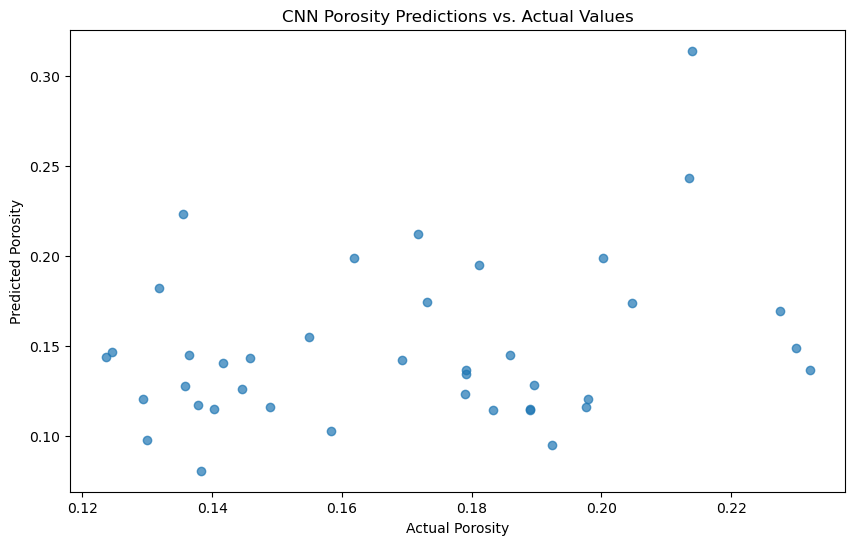

In [88]:
import matplotlib.pyplot as plt

actual_porosity = y_test

plt.figure(figsize=(10, 6))
plt.scatter(actual_porosity, predicted_porosity, alpha=0.7)
plt.title('CNN Porosity Predictions vs. Actual Values')
plt.xlabel('Actual Porosity')
plt.ylabel('Predicted Porosity')
plt.show()


In [89]:
print(actual_porosity)

[0.2002182  0.22991943 0.18904877 0.1791687  0.1791153  0.13775635
 0.19799805 0.21356964 0.16190338 0.16918182 0.13636017 0.13552094
 0.21398163 0.14160919 0.18597412 0.14588165 0.18954468 0.14463043
 0.15824127 0.23215485 0.12355042 0.18899536 0.17315674 0.1811142
 0.14026642 0.13819885 0.19763184 0.17169189 0.22750854 0.12457275
 0.1292572  0.15490723 0.19241333 0.20465088 0.18323517 0.13178253
 0.17901611 0.14891815 0.13574982 0.12991333]


In [90]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(actual_porosity, predicted_porosity)
mse = mean_squared_error(actual_porosity, predicted_porosity)
r2 = r2_score(actual_porosity, predicted_porosity)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Absolute Error: 0.04218196608126164
Mean Squared Error: 0.0026601380189662767
R-squared: -1.7309262444734492


In [91]:
Average_predicted_porosity = np.average(predicted_porosity)
Average_predicted_porosity = Average_predicted_porosity*100
print("The porosity for the testing data %0.2f" %Average_predicted_porosity, "%")

The porosity for the testing data 14.83 %


# APPENDIX
## **Example after remove noise, sugement and therhods** (using image "Crop_0000.png")

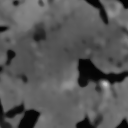

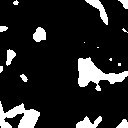

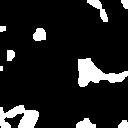

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


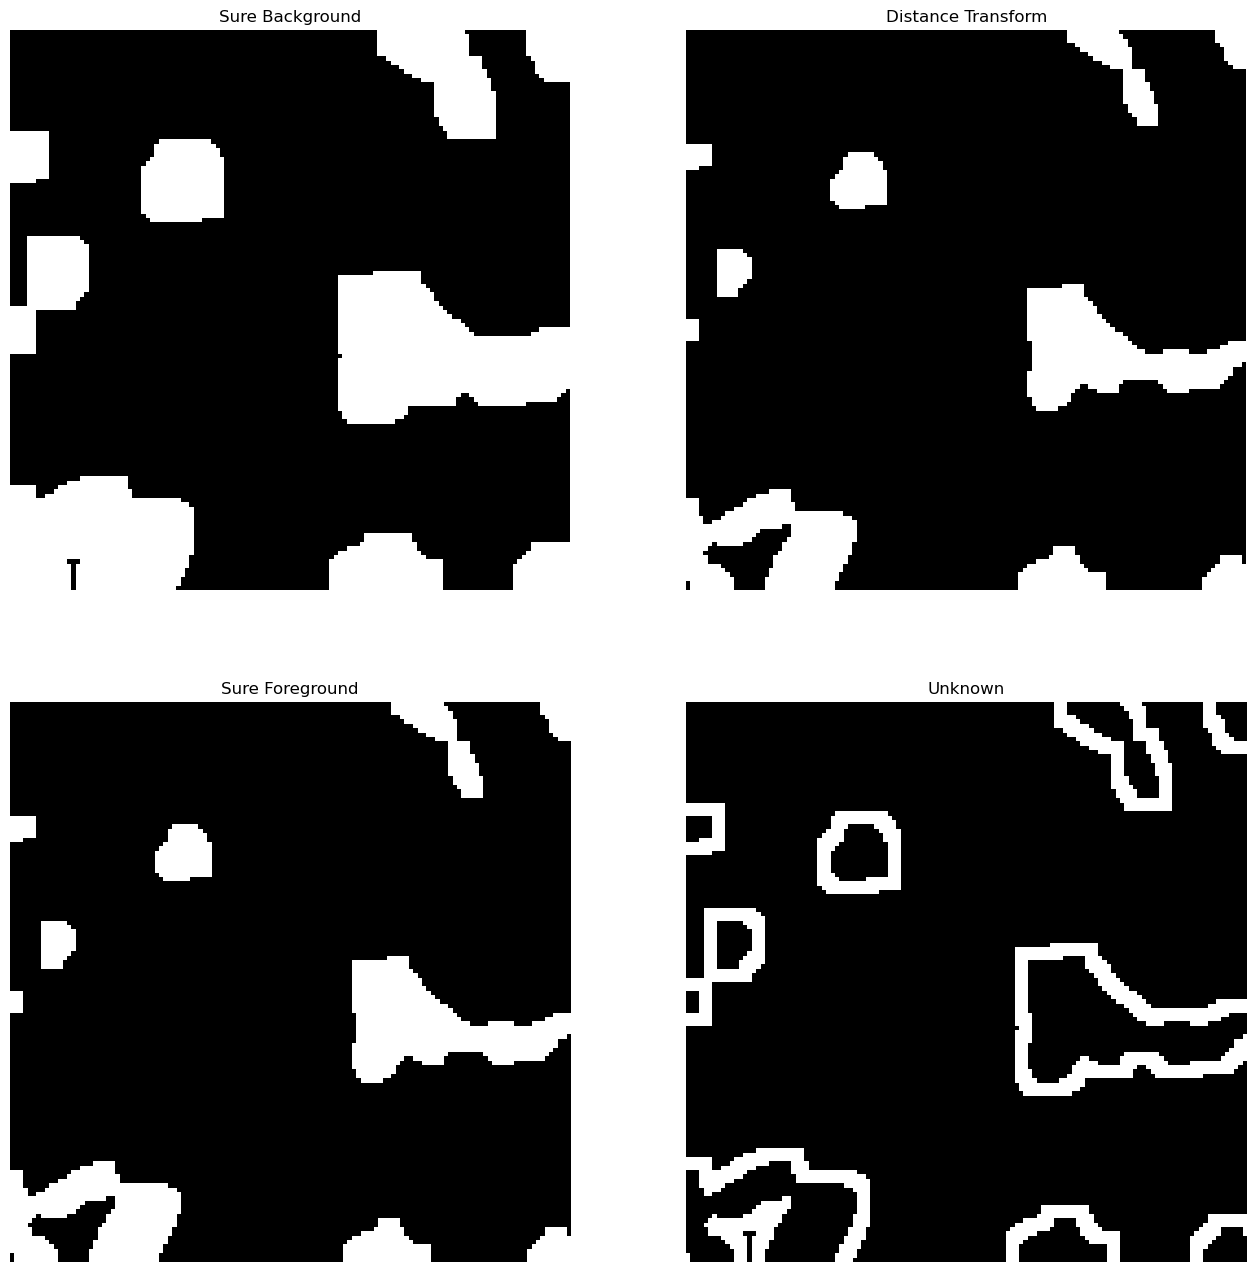

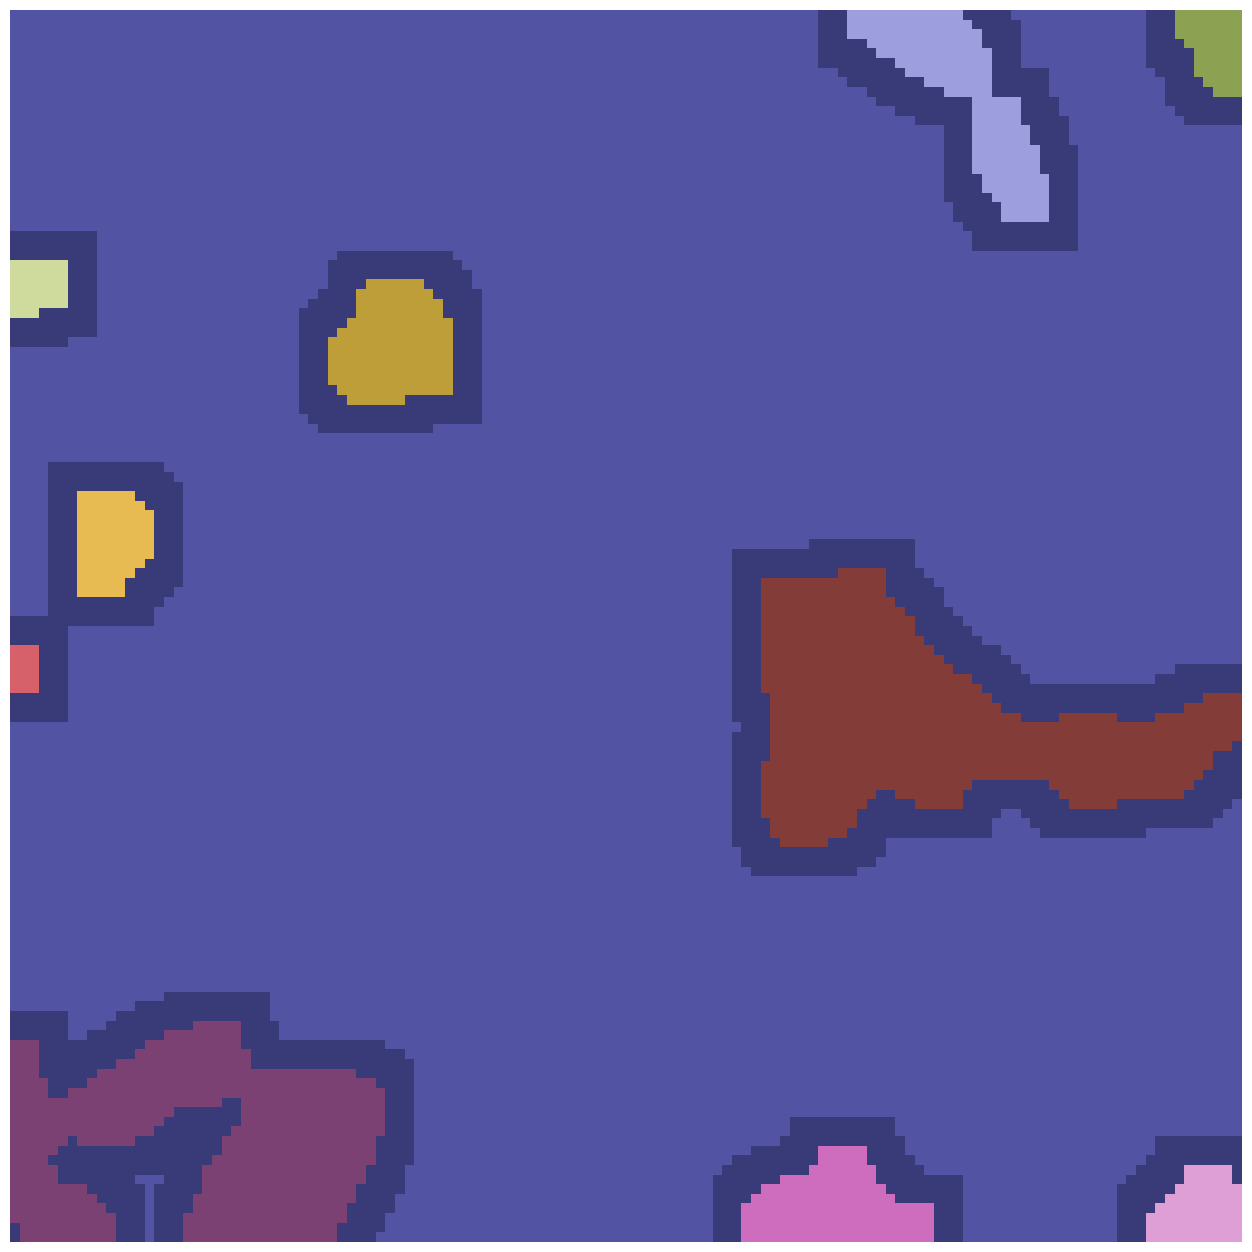

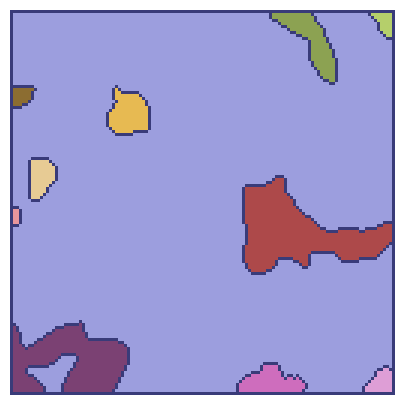

porosity 0.10076904296875


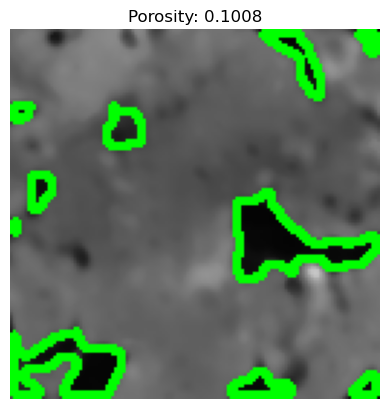

Porosity: 0.1008


In [71]:
import cv2
from IPython.display import Image, display
def imshow(img, ax=None):
    if ax is None:
        ret, encoded = cv2.imencode(".png", img)
        display(Image(encoded))
    else:
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')

img = cv2.imread('D:\\OU\\MINES\\CroppedImages\\crop_0001.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imshow(gray)
ret, bin_img = cv2.threshold(gray,
                             0, 255, 
                             cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
imshow(bin_img)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
bin_img = cv2.morphologyEx(bin_img, 
                           cv2.MORPH_OPEN,
                           kernel,
                           iterations=2)
imshow(bin_img)
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
# sure background area
sure_bg = cv2.dilate(bin_img, kernel, iterations=3)
imshow(sure_bg, axes[0,0])
axes[0, 0].set_title('Sure Background')
 
# Distance transform
dist = cv2.distanceTransform(bin_img, cv2.DIST_L2, 5)
imshow(dist, axes[0,1])
axes[0, 1].set_title('Distance Transform')
 
#foreground area
ret, sure_fg = cv2.threshold(dist, 0.1 * dist.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)  
imshow(sure_fg, axes[1,0])
axes[1, 0].set_title('Sure Foreground')
 
# unknown area
unknown = cv2.subtract(sure_bg, sure_fg)
imshow(unknown, axes[1,1])
axes[1, 1].set_title('Unknown')
 
plt.show()
# Marker labelling
# sure foreground 
ret, markers = cv2.connectedComponents(sure_fg)
 
# Add one to all labels so that background is not 0, but 1
markers += 1
# mark the region of unknown with zero
markers[unknown == 255] = 0

 
fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Apply the watershed algorithm
markers = cv2.watershed(img, markers)

# Visualization of the result
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()

# Process the labels to identify and calculate areas
labels = np.unique(markers)
rock = []

for label in labels[2:]:  # Exclude background and border labels
    target = np.where(markers == label, 255, 0).astype(np.uint8)
    contours, hierarchy = cv2.findContours(target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rock.append(contours[0])

# Draw the outlines for visualization
img_with_contours = cv2.drawContours(img.copy(), rock, -1, color=(0, 255, 0), thickness=2)

# Calculate porosity
total_pore_area = sum([cv2.contourArea(coin) for coin in rock])
total_image_area = img.shape[0] * img.shape[1]
porosity = total_pore_area / total_image_area
print("porosity",porosity)
# Show the final image with pore outlines
plt.imshow(img_with_contours, cmap='gray')
plt.title(f"Porosity: {porosity:.4f}")
plt.axis('off')
plt.show()

print(f"Porosity: {porosity:.4f}")